# Import


In [0]:
!pip3 install --upgrade tensorflow

In [0]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
import zipfile
import random
import cv2
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import math
from tensorflow import keras
import tensorflow as tf
import keras.backend as kb
from tensorflow.keras.layers import  Input,Conv2D,Conv2DTranspose,Concatenate,BatchNormalization,LeakyReLU,ReLU,Activation,Dropout,GaussianDropout
from tensorflow.keras.models import Model,Sequential,load_model,save_model
from tensorflow.keras.optimizers import Adam,RMSprop
from tensorflow.keras.utils import plot_model
from tensorflow.keras.activations import sigmoid,tanh,relu,elu
from tensorflow.keras.initializers import TruncatedNormal,RandomNormal
from tensorflow.keras.losses import BinaryCrossentropy,MAE,binary_crossentropy,MeanAbsoluteError
from tensorflow.keras.applications.vgg19 import VGG19
from time import perf_counter
from scipy.ndimage.filters import gaussian_filter1d
print(tf.__version__)
print(keras.__version__)

2.1.0
2.2.4-tf


Using TensorFlow backend.


# Loading and Preprocessing dataset


In [0]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
output_file = os.path.join("/content/", 'Image Deblurring Dataset.zip')
temp_file = drive.CreateFile({'id':'1DUjEvLKJWL8-7HTghZEe590NKiXYYnif'})
temp_file.GetContentFile(output_file)

In [0]:
output_file

'/content/Image Deblurring Dataset.zip'

In [0]:
zip_ref = zipfile.ZipFile('Image Deblurring Dataset.zip', 'r')
zip_ref.extractall()
zip_ref.close()

In [0]:
m_train = len(os.listdir("Image Deblurring Dataset/Train/Sharp Images"))
m_test = len(os.listdir("Image Deblurring Dataset/Test/Sharp Images"))
print("No. of Images In Training Set : "+str(m_train))
print("No. of Images In Testing Set : "+str(m_test))

No. of Images In Training Set : 125915
No. of Images In Testing Set : 5700


In [0]:
m_train = 125914#m_train-1
s = m_train/125915
s

0.9999920581344558

In [0]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=s)

In [0]:
d_seed = 1
mini_batch_size = 64
blurry    = image_generator.flow_from_directory("Image Deblurring Dataset/Train/",target_size=[256,256],batch_size = mini_batch_size,shuffle = True,classes=["Blurry Images"],class_mode=None,seed=d_seed,subset='validation')
benchmark = image_generator.flow_from_directory("Image Deblurring Dataset/Train/",target_size=[256,256],batch_size = mini_batch_size,shuffle = True,classes=["Sharp Images"],class_mode=None,seed=d_seed,subset='validation')
image_data = zip(blurry,benchmark)

Found 125914 images belonging to 1 classes.
Found 125914 images belonging to 1 classes.


In [0]:
m_test = m_test-1
st = m_test/5700
st

0.9998245614035087

In [0]:
image_generator_test = tf.keras.preprocessing.image.ImageDataGenerator(validation_split=st)

In [0]:
d_seed = 1
mini_batch_size_test = 8
blurry    = image_generator_test.flow_from_directory("Image Deblurring Dataset/Test/",target_size=[256,256],batch_size = mini_batch_size_test,shuffle = True,classes=["Blurry Images"],class_mode=None,seed=d_seed,subset='validation')
benchmark = image_generator_test.flow_from_directory("Image Deblurring Dataset/Test/",target_size=[256,256],batch_size = mini_batch_size_test,shuffle = True,classes=["Sharp Images"],class_mode=None,seed=d_seed,subset='validation')
image_data_test = zip(blurry,benchmark)

Found 5699 images belonging to 1 classes.
Found 5699 images belonging to 1 classes.


# Dataset Sample

In [0]:
for batch in image_data:
    batch = list(batch)
    print("Image batch shape: ", batch[0].shape)
    break
batch[0] = (batch[0]-127.5)/127.5 
batch[1] = (batch[1]-127.5)/127.5 
batch[0][np.where(batch[0] > 1)]= 1
batch[0][np.where(batch[0] < -1)]=-1
batch[1][np.where(batch[1] > 1)]= 1
batch[1][np.where(batch[1] < -1)]=-1   
print("Blurry Batch Statistical Analysis")
print("Standard Deviation = "+str(batch[0].std()))             
print("Variance = "+str(batch[0].var()))
print("Mean = "+str(batch[0].mean()))
print("Max = "+str(batch[0].max()))
print("Min = "+str(batch[0].min()))
print("Shape = "+str(batch[0].shape))
print("================================")
print("Sharp Batch Statistical Analysis")
print("Standard Deviation = "+str(batch[1].std())) 
print("Variance = "+str(batch[1].var()))
print("Mean = "+str(batch[1].mean()))
print("Max = "+str(batch[1].max()))
print("Min = "+str(batch[1].min()))
print("Shape = "+str(batch[1].shape))

Image batch shape:  (64, 256, 256, 3)
Blurry Batch Statistical Analysis
Standard Deviation = 0.54690194
Variance = 0.29910174
Mean = -0.100661434
Max = 1.0
Min = -1.0
Shape = (64, 256, 256, 3)
Sharp Batch Statistical Analysis
Standard Deviation = 0.5607776
Variance = 0.31447154
Mean = -0.11850647
Max = 1.0
Min = -1.0
Shape = (64, 256, 256, 3)


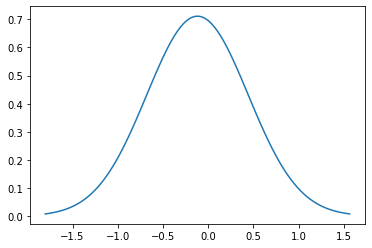

In [0]:
import scipy.stats as stats
x = np.linspace(batch[1].mean() - 3*batch[1].std(), batch[1].mean() + 3*batch[1].std(), 100)
plt.plot(x, stats.norm.pdf(x, batch[1].mean(), batch[1].std()))
plt.show()

In [0]:
batch[0] = (batch[0]+1)/2.0 
batch[1] = (batch[1]+1)/2.0 

3


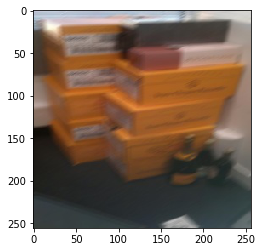

In [0]:
a = random.randint(0,batch[0].shape[0]-1)
print(a)
plt.imshow(batch[0][a])
plt.show()

In [0]:
ppp = batch[0][a]

In [0]:
ppp.shape
ppp = ppp.reshape(1,256,256,3)

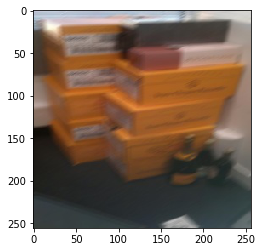

In [0]:
plt.imshow(ppp[0])
ppp[0] = (ppp[0]-0.5)/0.5 
ppp[0][np.where(ppp[0] > 1)]= 1
ppp[0][np.where(ppp[0] < -1)]=-1

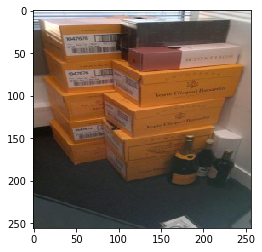

In [0]:
plt.imshow(batch[1][a])
plt.show()

# Hyper-Parameters and helper functions

In [0]:
learning_rate = 0.0001

In [0]:
def convert(seconds): 
    seconds = seconds % (24 * 3600) 
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
      
    return "Approx Time Required = %d:%02d:%02d" % (hour, minutes, seconds)

# Discriminator

In [0]:
def discriminator():
    inpt = Input(shape=(256,256,3))
    k_init = TruncatedNormal(mean=0.0,stddev=0.02,seed=1) 
    #k_init = RandomNormal(stddev=0.02)

    #X(m,256,256,3)
    L1 = Conv2D(filters=64,kernel_size=3,strides=(2,2),padding='same', kernel_initializer=k_init)(inpt)
    #L1 = BatchNormalization()(L1)
    L1 = LeakyReLU(alpha = 0.2)(L1)
    #(m,128,128,64)
    L2 = Conv2D(filters=128,kernel_size=3,strides=(2,2),padding='same', kernel_initializer=k_init)(L1)
    L2 = BatchNormalization()(L2)
    L2 = LeakyReLU(alpha = 0.2)(L2)
    #(m,64,64,128)   
    L3 = Conv2D(filters=256,kernel_size=3,strides=(2,2),padding='same', kernel_initializer=k_init)(L2)
    L3 = BatchNormalization()(L3)
    L3 = LeakyReLU(alpha = 0.2)(L3)
    #(m,32,32,256)
    L4 = Conv2D(filters=512,kernel_size=3,strides=(2,2),padding='same', kernel_initializer=k_init)(L3)
    L4 = BatchNormalization()(L4)
    L4 = LeakyReLU(alpha = 0.2)(L4)
    #(m,16,16,512)
    L5 = Conv2D(filters=512,kernel_size=3,strides=(1,1),padding='same', kernel_initializer=k_init)(L4)
    L5 = BatchNormalization()(L5)
    L5 = LeakyReLU(alpha = 0.2)(L5)
    #(m,16,16,512)
    L6 = Conv2D(filters=1,kernel_size=1,strides=(1,1),padding='same', kernel_initializer=k_init,activation=sigmoid)(L5)
    L6W = Conv2D(filters=1,kernel_size=1,strides=(1,1),padding='same', kernel_initializer=k_init,activation=relu)(L5)
    #(m,16,16,1)

    discriminator = Model(inputs=inpt, outputs=[L6,L6W])

    return discriminator

In [0]:
d = discriminator()
#d.summary()
#plot_model(d, to_file='Dis.png', show_shapes=True, show_layer_names=True,dpi=50)

# Translator


In [0]:
def translator():
    inpt = Input(shape=(256,256,3))
    k_init = TruncatedNormal(mean=0.0,stddev=0.02,seed=1)
    #k_init = RandomNormal(stddev=0.02)
    #X(m,256,256,3)
    L1 = Conv2D(filters=64,kernel_size=3,strides=(2,2),padding='same', kernel_initializer=k_init)(inpt)
    #L1 = BatchNormalization()(L1)
    L1 = LeakyReLU(alpha = 0.2)(L1)
    #(m,128,128,64)

    L2 = Conv2D(filters=128,kernel_size=3,strides=(2,2),padding='same', kernel_initializer=k_init)(L1)
    #(m,64,64,128)
    #L2 = MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='valid')(L2)
    L2 = BatchNormalization()(L2)
    L2 = LeakyReLU(alpha = 0.2)(L2)
    #(m,64,64,128)

    L3 = Conv2D(filters=256,kernel_size=3,strides=(2,2),padding='same', kernel_initializer=k_init)(L2)
    L3 = BatchNormalization()(L3)
    L3 = LeakyReLU(alpha = 0.2)(L3)
    #(m,32,32,256)

    L4 = Conv2D(filters=512,kernel_size=3,strides=(2,2),padding='same', kernel_initializer=k_init)(L3)
    L4 = BatchNormalization()(L4)
    L4 = LeakyReLU(alpha = 0.2)(L4)
    #(m,16,16,512)

    L5 = Conv2D(filters=512,kernel_size=3,strides=(2,2),padding='same', kernel_initializer=k_init)(L4)
    L5 = BatchNormalization()(L5)
    L5 = LeakyReLU(alpha = 0.2)(L5)
    #(m,8,8,512)

    L6 = Conv2D(filters=512,kernel_size=3,strides=(2,2),padding='same', kernel_initializer=k_init)(L5)
    L6 = BatchNormalization()(L6)
    L6 = LeakyReLU(alpha = 0.2)(L6)
    #(m,4,4,512)

    L7 = Conv2D(filters=512,kernel_size=3,strides=(2,2),padding='same', kernel_initializer=k_init)(L6)
    L7 = BatchNormalization()(L7)
    L7 = LeakyReLU(alpha = 0.2)(L7)
    #(m,2,2,512)

    L8 = Conv2D(filters=512,kernel_size=3,strides=(2,2),padding='same', kernel_initializer=k_init)(L7)
    L8 = BatchNormalization()(L8)
    L8 = LeakyReLU(alpha = 0.2)(L8)
    #(m,1,1,512)

    
    D1 = Conv2DTranspose(filters=512,kernel_size=3,strides=(2, 2),padding='same', kernel_initializer=k_init)(L8)
    D1 = BatchNormalization()(D1)
    #D1 = Dropout(0.5)(D1, training=True)
    D1 = tf.keras.backend.dropout(D1,0.5)
    D1 = relu(D1)
    D1 = Concatenate()([D1,L7])
    #(m,2,2,1024)

    D2 = Conv2DTranspose(filters=512,kernel_size=3,strides=(2, 2),padding='same', kernel_initializer=k_init)(D1)
    D2 = BatchNormalization()(D2)
    #D2 = Dropout(0.5)(D2, training=True)
    D2 = tf.keras.backend.dropout(D2,0.5)
    D2 = relu(D2)
    D2 = Concatenate()([D2,L6])
    #(m,4,4,1024)  

    D3 = Conv2DTranspose(filters=512,kernel_size=3,strides=(2, 2),padding='same', kernel_initializer=k_init)(D2)
    D3 = BatchNormalization()(D3)
    #D3 = Dropout(0.5)(D3, training=True)
    D3 = tf.keras.backend.dropout(D3,0.5)
    D3 = relu(D3)
    D3 = Concatenate()([D3,L5])
    #(m,8,8,1024)

    D4 = Conv2DTranspose(filters=512,kernel_size=3,strides=(2, 2),padding='same', kernel_initializer=k_init)(D3)
    D4 = BatchNormalization()(D4)
    D4 = relu(D4)
    D4 = Concatenate()([D4,L4])
    #D4 = UpSampling2D()(D3)
    #(m,16,16,1024)   

    D5 = Conv2DTranspose(filters=256,kernel_size=3,strides=(2, 2),padding='same', kernel_initializer=k_init)(D4)
    D5 = BatchNormalization()(D5)
    D5 = relu(D5)
    D5 = Concatenate()([D5,L3])
    #(m,32,32,512)

    D6 = Conv2DTranspose(filters=128,kernel_size=3,strides=(2, 2),padding='same', kernel_initializer=k_init)(D5)
    D6 = BatchNormalization()(D6)
    D6 = relu(D6)
    D6 = Concatenate()([D6,L2])
    #D6 = UpSampling2D()(D5)
    #(m,64,64,256)

    D7 = Conv2DTranspose(filters=64,kernel_size=3,strides=(2, 2),padding='same', kernel_initializer=k_init)(D6)
    D7 = BatchNormalization()(D7)
    D7 = relu(D7)
    D7 = Concatenate()([D7,L1])
    #(m,128,128,128)

    D8 = Conv2DTranspose(filters=3,kernel_size=3,strides=(2, 2),padding='same',kernel_initializer=k_init)(D7)
    D8 = BatchNormalization()(D8)
    D8 = Activation('tanh')(D8)
    #(m,256,256,3)
    translator = Model(inputs=inpt, outputs=D8)

    return translator

In [0]:
t = translator()
#t.summary()
#plot_model(t, to_file='Tran.png', show_shapes=True, show_layer_names=True,dpi=50)

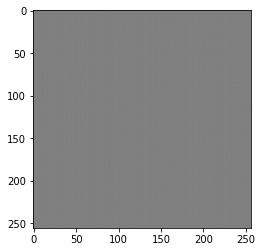

In [0]:
i = t.predict(np.random.rand(1,256,256,3))
plt.imshow((i[0]+1)/2)
plt.show()

# Loss


In [0]:
vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=[256,256,3])
vgg19.trainable = False
for lyr in vgg19.layers:
    lyr.trainable = False
#vgg19.summary()
#plot_model(vgg19, to_file='d_b_c.png', show_shapes=True, show_layer_names=True)            

80142336/80134624 [==============================] - 6s 0us/step


In [0]:
def PerceptualLoss(benchmark_batch, blurry_batch):
    v = Model(inputs=vgg19.input, outputs=vgg19.get_layer('block3_conv4').output)
    v.trainable = False
    return kb.mean(kb.square(v(benchmark_batch)-v(blurry_batch)))

In [0]:
def WassersteinLoss(y_true,y_pred):
	return kb.mean(y_true)*kb.mean(y_pred)

In [0]:
def TranslatorLoss_Model():   
    inp = Input(shape=(256,256,3))
    t_out = t(inp)
    d.trainable = False
    d_out,d_out_W = d(t_out)
    tl_m = Model(inputs=inp ,outputs= [t_out,d_out_W,d_out,t_out])
    tl_m.compile(optimizer=Adam(learning_rate, beta_1=0.5,beta_2=0.999),loss=[PerceptualLoss,WassersteinLoss,'binary_crossentropy','mae'],loss_weights=[50,0.00001,0.0001,5])
    d.trainable = True
    return tl_m

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
model_1 (Model)              (None, 256, 256, 3)       30629583  
_________________________________________________________________
model (Model)                [(None, 16, 16, 1), (None 3917442   
Total params: 30,632,399
Trainable params: 30,618,697
Non-trainable params: 13,702
_________________________________________________________________


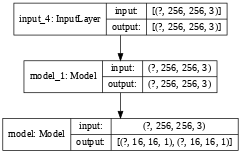

In [0]:
tl_m = TranslatorLoss_Model()
tl_m.summary()
plot_model(tl_m,to_file='Tran.png', show_shapes=True, show_layer_names=True,dpi=50)

In [0]:
def DiscriminatorLoss_Model():   
    inp = Input(shape=(256,256,3))
    d_out,d_out_W = d(inp)
    dl_m = Model(inputs = inp , outputs= [d_out_W,d_out])
    dl_m.compile(optimizer=Adam(learning_rate, beta_1=0.5,beta_2=0.999),loss=[WassersteinLoss,'binary_crossentropy'],loss_weights=[0.5,0.5])   
    return dl_m

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
model (Model)                [(None, 16, 16, 1), (None 3917442   
Total params: 3,917,442
Trainable params: 3,914,626
Non-trainable params: 2,816
_________________________________________________________________


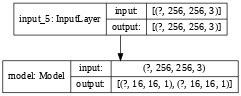

In [0]:
dl_m = DiscriminatorLoss_Model()
dl_m.summary()
plot_model(dl_m,to_file='Tran.png', show_shapes=True, show_layer_names=True,dpi=50)

# Train 1

In [0]:
def train(t_model,d_model,epochs = 10):
    
    d_cost1,d_cost2,d_cost,t_cost1,t_cost2,t_cost3,t_cost4,t_cost5,d_b_cost1,d_b_cost2=0,0,0,0,0,0,0,0,0,0
    N_batches = m_train//mini_batch_size
    total_batches = N_batches*epochs
    i,j,total_time,flag=1,1,0,0
    start_time = perf_counter()
    for batch in image_data:
        batch = list(batch)
        batch[0] = (batch[0]-127.5)/127.5 
        batch[1] = (batch[1]-127.5)/127.5 
        batch[0][np.where(batch[0] > 1)]= 1
        batch[0][np.where(batch[0] < -1)]=-1
        batch[1][np.where(batch[1] > 1)]= 1
        batch[1][np.where(batch[1] < -1)]=-1
        t_out = t_model(batch[0])
        d_out_shape = np.random.rand(len(batch[0]),16,16,1)

        Discriminator_Loss1,Wasserstein_Loss_blurry,Adv_loss_blurry = dl_m.train_on_batch(x=t_out,y=[-1*np.ones_like(d_out_shape),np.zeros_like(d_out_shape)])
        Discriminator_Loss2,Wasserstein_Loss_benchmark,Adv_loss_benchmark = dl_m.train_on_batch(x=batch[1],y=[np.ones_like(d_out_shape),np.ones_like(d_out_shape)]) 
        Discriminator_Loss = Discriminator_Loss1+Discriminator_Loss2
        d_costs_benchmark_W.append(Wasserstein_Loss_benchmark)
        d_costs_blurry_W.append(Wasserstein_Loss_blurry)
        d_costs_benchmark_b_c.append(Adv_loss_benchmark)
        d_costs_blurry_b_c.append(Adv_loss_blurry)
        d_costs.append(Discriminator_Loss)
        d_cost1 += Wasserstein_Loss_benchmark
        d_cost2 += Wasserstein_Loss_blurry
        d_b_cost1 += Adv_loss_benchmark
        d_b_cost2 += Adv_loss_blurry
        d_cost += Discriminator_Loss

        dl_m.trainable = False
        Translator_Loss, Perceptual_Loss,Wasserstein_Loss,Adv_loss,L1_loss  = tl_m.train_on_batch(x=batch[0],y=[batch[1],np.ones_like(d_out_shape),np.ones_like(d_out_shape),batch[1]])
        dl_m.trainable = True
        t_costs_b_c.append(Adv_loss)
        t_costs_W.append(Wasserstein_Loss)
        t_costs_l1.append(L1_loss)
        t_costs_P.append(Perceptual_Loss)
        t_costs.append(Translator_Loss)
        t_cost1 += Perceptual_Loss
        t_cost2 += Wasserstein_Loss
        t_cost3 += Adv_loss
        t_cost4 += L1_loss
        t_cost5 += Translator_Loss


        tst = t.predict(ppp)
        tst = (tst+1)/2.0
        tst = np.reshape(np.array(tst),(256,256,3))
        b.append(tst)

        if j<=20 and flag==0:
            end_time = perf_counter()
            total_time = total_time + (end_time-start_time)
            start_time = perf_counter()
        if j==20 and flag==0:
            total_time = total_time/20
            total_time = total_time*total_batches
            print(convert(total_time))
            flag=1
        if j==N_batches:
            j=0
            d_cost1 = d_cost1/N_batches
            d_cost2 = d_cost2/N_batches
            d_b_cost1 = d_b_cost1/N_batches
            d_b_cost2 = d_b_cost2/N_batches
            d_cost = d_cost/N_batches
            t_cost1 = t_cost1/N_batches
            t_cost2 = t_cost2/N_batches
            t_cost3 = t_cost3/N_batches
            t_cost4 = t_cost4/N_batches
            t_cost5 = t_cost5/N_batches
            print("Epochs : "+str(i) + " : DIS_COST  "+str(d_cost)+'(DL) | '+str(d_cost1)+'(W_R) , '+str(d_cost2)+'(W_F) , '+str(d_b_cost1)+'(B_C_R) , '+str(d_b_cost2)+'(B_C_F)') 
            print("Epochs : "+str(i) + " : GEN_COST  "+str(t_cost5)+'(TL) | '+str(t_cost1)+'(P) , '+str(t_cost2)+'(W) , '+str(t_cost3)+'(B_C) , '+str(t_cost4)+'(L1)' )
            a = random.randint(0,batch[0].shape[0]-1)
            tst_img = t_model.predict(batch[0][a:a+1,:,:,:])
            tst_img = np.reshape(np.array(tst_img),(256,256,3))
            tst_img_b = np.reshape(np.array(batch[0][a:a+1,:,:,:]),(256,256,3))
            tst_img_bn = np.reshape(np.array(batch[1][a:a+1,:,:,:]),(256,256,3))
            tst_img = (tst_img+1)/2.0
            tst_img_b = (tst_img_b+1)/2.0
            tst_img_bn = (tst_img_bn+1)/2.0
            plt.axis('off')
            plt.subplot(1,3,1),plt.imshow(tst_img_b)
            plt.axis('off')
            plt.subplot(1,3,2),plt.imshow(tst_img_bn)
            plt.axis('off')
            plt.subplot(1,3,3),plt.imshow(tst_img)
            plt.xticks([]),plt.yticks([])
            plt.show()
            d_cost1,d_cost2,d_cost,t_cost1,t_cost2,t_cost3,t_cost4,t_cost5,d_b_cost1,d_b_cost2=0,0,0,0,0,0,0,0,0,0
            epochs=epochs-1
            i=i+1
            if epochs==0:
                break
        j=j+1
    print('Congratulations,Your model is successfully trained.')
    return 

In [0]:
def plot_cost_curve():

    epoch = [i for i in range(1,len(t_costs_P)+1)]
    
    d_costs_benchmark_b_c_smooth = gaussian_filter1d(d_costs_benchmark_b_c, sigma=9)
    d_costs_blurry_b_c_smooth = gaussian_filter1d(d_costs_blurry_b_c, sigma=9)
    plt.plot(epoch,d_costs_benchmark_b_c_smooth,color='green',linewidth = 0.5,label = "Sharp Images")
    plt.plot(epoch,d_costs_blurry_b_c_smooth,color='black',linewidth = 0.5,label = "Deblurred Images")
    plt.ylabel('Cost')
    plt.xlabel('Number of batches')
    plt.title("Discriminator Binary Crossentropy Loss")
    plt.legend() 
    plt.show()

    d_costs_benchmark_W_smooth = gaussian_filter1d(d_costs_benchmark_W, sigma=9)
    d_costs_blurry_W_smooth = gaussian_filter1d(d_costs_blurry_W, sigma=9)
    plt.plot(epoch,d_costs_benchmark_W_smooth,color='green',linewidth = 0.5,label = "Sharp Images")
    plt.plot(epoch,d_costs_blurry_W_smooth,color='black',linewidth = 0.5,label = "Deblurred Images")
    plt.ylabel('Cost')
    plt.xlabel('Number of batches')
    plt.title('Discriminator Wasserstein Loss')
    plt.legend() 
    plt.show()

    t_costs_b_c_smooth = gaussian_filter1d(t_costs_b_c, sigma=9)
    plt.plot(epoch,t_costs_b_c_smooth,color='blue',linewidth = 0.5)
    plt.ylabel('Cost')
    plt.xlabel('Number of batches')
    plt.title('Translator Binary Crossentropy Loss')
    plt.legend() 
    plt.show()
    
    t_costs_P_smooth = gaussian_filter1d(t_costs_P, sigma=9)
    plt.plot(epoch,t_costs_P_smooth,color='green',linewidth = 0.5)
    plt.ylabel('Cost')
    plt.xlabel('Number of batches')
    plt.title('Translator Perceptual Loss')
    plt.legend() 
    plt.show()
    
    t_costs_W_smooth = gaussian_filter1d(t_costs_W, sigma=9)
    plt.plot(epoch,t_costs_W_smooth,color='blue',linewidth = 0.5)
    plt.ylabel('Cost')
    plt.xlabel('Number of batches')
    plt.title('Translator Wasserstein Loss')
    plt.legend() 
    plt.show()
  
    t_costs_l1_smooth = gaussian_filter1d(t_costs_l1, sigma=9)
    plt.plot(epoch,t_costs_l1_smooth,color='green',linewidth = 0.5)
    plt.ylabel('Cost')
    plt.xlabel('Number of batches')
    plt.title('Translator L1 Loss (MAE)')
    plt.legend() 
    plt.show()

    t_costs_smooth = gaussian_filter1d(t_costs, sigma=9)
    plt.plot(epoch,t_costs_smooth,color='blue',linewidth = 0.5)
    plt.ylabel('Cost')
    plt.xlabel('Number of batches')
    plt.title('Translator Loss')
    plt.legend() 
    plt.show()

    d_costs_smooth = gaussian_filter1d(d_costs, sigma=9)
    plt.plot(epoch,d_costs_smooth,color='green',linewidth = 0.5)
    plt.ylabel('Cost')
    plt.xlabel('Number of batches')
    plt.title('Discriminator Loss')
    plt.legend() 
    plt.show()


# Train 2

In [0]:
d_costs_benchmark_W=[]
d_costs_blurry_W=[]
d_costs_benchmark_b_c=[]
d_costs_blurry_b_c=[]
t_costs_b_c=[]
t_costs_l1=[]
t_costs_W=[]
t_costs_P=[]
t_costs = []
d_costs = []
b = []

Approx Time Required = 0:57:22
Epochs : 1 : DIS_COST  -40.902210992911044(DL) | 0.5310763470584439(W_R) , -82.9023147567493(W_F) , 0.3440527576568712(B_C_R) , 0.22276368150871056(B_C_F)
Epochs : 1 : GEN_COST  2180.0717314199924(TL) | 43.5841405390481(P) , 25.706762981463278(W) , 0.5897866982036759(B_C) , 0.17288555369258352(L1)


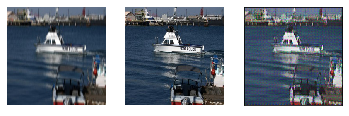

Congratulations,Your model is successfully trained.


In [0]:
learning_rate = 0.0001
e=1
train(t,d,epochs = e)

Approx Time Required = 0:56:16
Epochs : 1 : DIS_COST  -167.86532240975734(DL) | 2.5364772632318475(W_R) , -338.80763955981706(W_F) , 0.30671013256105967(B_C_R) , 0.23380744029224737(B_C_F)
Epochs : 1 : GEN_COST  1303.9692520894068(TL) | 26.06556021918727(P) , 104.48518880466914(W) , 0.19603376379156087(B_C) , 0.13803991717042569(L1)


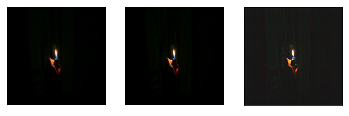

Congratulations,Your model is successfully trained.


In [0]:
learning_rate = 0.00005
e=1
train(t,d,epochs = e)

Approx Time Required = 0:56:31
Epochs : 1 : DIS_COST  -254.83951423540296(DL) | 3.523577548777254(W_R) , -513.7715808459205(W_F) , 0.3201162967060081(B_C_R) , 0.24885815615331575(B_C_F)
Epochs : 1 : GEN_COST  1171.1185564313616(TL) | 23.409054851677432(P) , 154.1442964958187(W) , 0.2094848035978192(B_C) , 0.1328544799422151(L1)


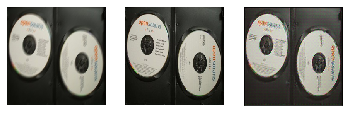

Congratulations,Your model is successfully trained.


In [0]:
learning_rate = 0.00004
e=1
train(t,d,epochs = e)

Approx Time Required = 0:57:46
Epochs : 1 : DIS_COST  -355.8932965137538(DL) | 4.385513812049288(W_R) , -716.7862017136512(W_F) , 0.3420423567446586(B_C_R) , 0.27205154789875896(B_C_F)
Epochs : 1 : GEN_COST  1073.7317703472036(TL) | 21.461614032778332(P) , 209.1995010802633(W) , 0.2690148403764862(B_C) , 0.12979434601049708(L1)


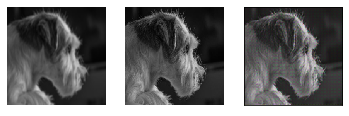

Congratulations,Your model is successfully trained.


In [0]:
learning_rate = 0.000032
e=1
train(t,d,epochs = e)

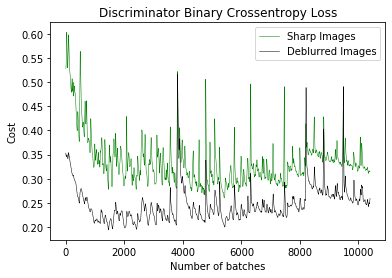

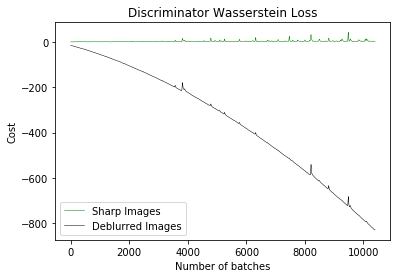

No handles with labels found to put in legend.


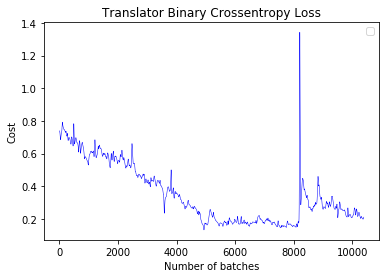

No handles with labels found to put in legend.


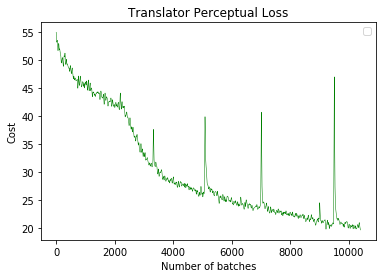

No handles with labels found to put in legend.


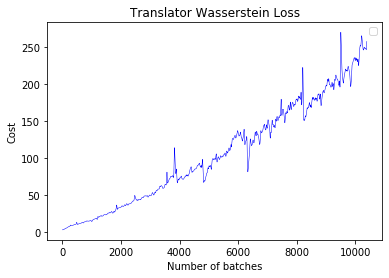

No handles with labels found to put in legend.


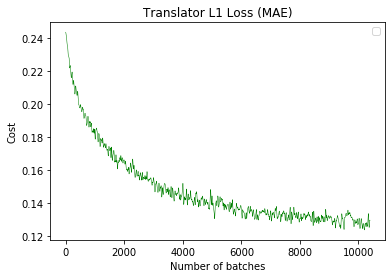

No handles with labels found to put in legend.


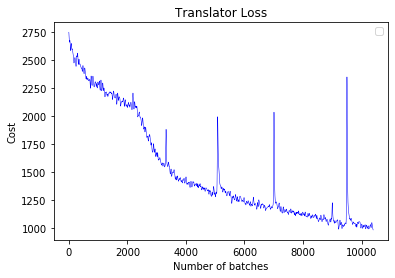

No handles with labels found to put in legend.


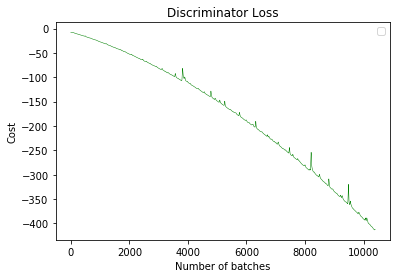

In [0]:
plot_cost_curve()

# Saving Model Weights

In [0]:
converter = tf.lite.TFLiteConverter.from_keras_model(t)
#converter.post_training_quantize=True
tflite_model = converter.convert()
tflite_model_name = "My_model_lite.tflite"
open(tflite_model_name, "wb").write(tflite_model)

122641288

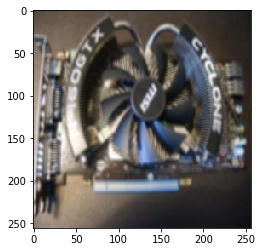

In [0]:
for batch in image_data_test:
        batch = list(batch)
        batch[0] = (batch[0]-127.5)/127.5 
        batch[1] = (batch[1]-127.5)/127.5 
        batch[0][np.where(batch[0] > 1)]= 1
        batch[0][np.where(batch[0] < -1)]=-1
        batch[1][np.where(batch[1] > 1)]= 1
        batch[1][np.where(batch[1] < -1)]=-1
        input_data = batch[0][0].reshape(1,256,256,3)
        break
plt.imshow((input_data[0]+1)/2)
plt.show()

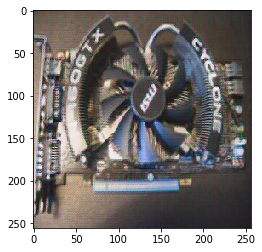

In [0]:
interpreter = tf.lite.Interpreter(model_path="/content/My_model_lite.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details() 
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
input_data = batch[0][0].reshape(1,256,256,3)

interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
output_data = (output_data+1)/2
plt.imshow(output_data[0])
plt.show()

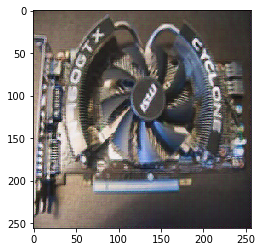

In [0]:
output_data = t.predict(batch[0])
output_data = (output_data+1)/2
plt.imshow(output_data[0])
plt.show()

In [0]:
from google.colab import files
files.download('/content/My_model_lite.tflite')

In [0]:
#save_model(t,"My_model_tran.h5")
#save_model(d,"My_model_dis.h5")
#save_model(dl_m,"My_model_d_l.h5")
#save_model(tl_m"My_model_t_l.h5")
#t = load_model('My_model_tran.h5')

#  Testing 

In [0]:
def peek_signal2noise_ratio(orig_img,convrtd_img):
    MSE = (np.mean((orig_img-convrtd_img)**2))/(255*255)
    PSNR = 10*math.log10(1/MSE)
    return PSNR

In [0]:
tt = t#load_model('My_model_tran.h5')
#dd = load_model("My_model_dis.h5")
#mm = load_model("My_model_m.h5")
#tt.summary()

In [0]:
for batch in image_data:
    batch = list(batch)
    batch[0] = (batch[0]-127.5)/127.5 
    batch[1] = (batch[1]-127.5)/127.5 
    batch[0][np.where(batch[0] > 1)]= 1
    batch[0][np.where(batch[0] < -1)]=-1
    batch[1][np.where(batch[1] > 1)]= 1
    batch[1][np.where(batch[1] < -1)]=-1
    tst_img = tt.predict(batch[0])
    tst_img_b = batch[0]
    tst_img_bn = batch[1]
    break

In [0]:
a = random.randint(0,batch[0].shape[0]-1)
img = tst_img[a:a+1,:,:,:]
img_b = tst_img_b[a:a+1,:,:,:]
img_bn = tst_img_bn[a:a+1,:,:,:]
img = (img+1)/2.0
img_b = (img_b+1)/2.0
img_bn = (img_bn+1)/2.0

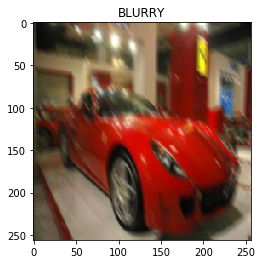

In [0]:
plt.imshow(img_b[0])
plt.title('BLURRY')
plt.show()

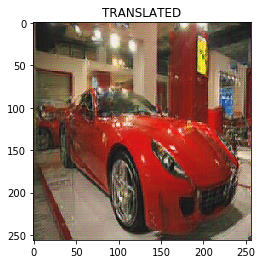

In [0]:
plt.imshow(img[0])
plt.title('TRANSLATED')
plt.show()

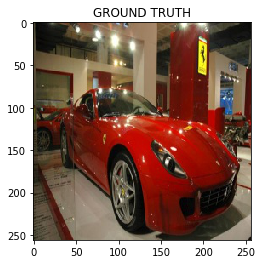

In [0]:
plt.imshow(img_bn[0])
plt.title('GROUND TRUTH')
plt.show()

In [0]:
print('PSNR(S-B) : '+str(peek_signal2noise_ratio(img_bn[0],img_b[0])))
print('PSNR(B-T) : '+str(peek_signal2noise_ratio(img_b[0],img[0])))
print('PSNR(S-T) : '+str(peek_signal2noise_ratio(img_bn[0],img[0])))
print('PSNR(S-T) : '+str(cv2.PSNR(img_bn[0],img[0])))
print('PSNR(S-T) : '+str(tf.image.psnr(tf.convert_to_tensor(img_bn),tf.convert_to_tensor(img),max_val=255).numpy()[0]))
print('SSIM(S-T) : '+str(tf.image.ssim(tf.convert_to_tensor(img_bn),tf.convert_to_tensor(img),max_val=255).numpy()[0]))

PSNR(S-B) : 71.30154771693272
PSNR(B-T) : 70.71102367157872
PSNR(S-T) : 68.17702756455603
PSNR(S-T) : 68.177027377738
PSNR(S-T) : 68.177025
SSIM(S-T) : 0.9992206
